# Зависимость надоя и кормежки

In [138]:
import datetime
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
sns.set_theme(context='talk', style='whitegrid', palette='deep')
plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['figure.titlesize'] = 32
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['figure.autolayout'] = 'true'
plt.rcParams['figure.frameon'] = 'false'
plt.rcParams['axes.spines.left'] = 'false'
plt.rcParams['axes.spines.right'] = 'false'
plt.rcParams['axes.spines.top'] = 'false'
plt.rcParams['legend.fancybox'] = 'false'
plt.rcParams['axes.spines.bottom'] = 'false'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# для графиков, где надо много цветов, юзайте воть:
sns.set_palette(sns.color_palette('deep'))
# а по дефолту воть:
sns.set_palette(sns.color_palette('BuGn_r', n_colors=10)[2::3])
pd.set_option('display.max_columns', 60)

In [139]:
herd_metrics = pd.read_excel("datasets/Ekoniva_dataset.xlsx", sheet_name="Herd maintenance").replace("-", np.nan)
production_indicators = pd.read_excel("datasets/Ekoniva_dataset.xlsx", sheet_name="Dairy indicators").replace("-", np.nan)

,date,region,prod_farm_name,farm_type,farm_name,cows_total,milk_cows,milk_cows_d0,milk_cows_d1,milk_cows_d2,milk_cows_d3,weekly_milking_per_cow,gross_milk_yield,cow_retired,cow_retired_low_prod,cow_retired_hooves,cow_retired_inj_joint,cow_retired_mastit,cow_retired_jkt,bull_num,year_month,Concentrate,Forage,Medication,VitaminMineral,Water,dist_to_center_euclid,dist_to_center_manhattan,pca1,pca2,cluster_kmeans,cluster_dbscan
0,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров,2878.0,2609.0,69.0,2094.0,340.0,106.0,34.1,86551.0,0.0,NaN,NaN,NaN,NaN,NaN,23.0,2022-11,11.707062,26.827813,0.0,0.215386,5.563448,1.018936,1.957514,-0.150636,0.917853,2,0
1,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Верхний Икорец,2893.0,2580.0,101.0,2104.0,375.0,0.0,38.3,98563.0,85.0,NaN,NaN,NaN,NaN,NaN,0.0,2022-11,13.070017,27.006349,0.0,0.272975,6.542931,1.455630,2.485437,-0.008659,1.384267,2,0
2,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Петропавловка,2885.0,2686.0,90.0,2271.0,163.0,162.0,35.2,87647.0,153.0,NaN,NaN,NaN,NaN,NaN,26.0,2022-11,13.353972,31.202231,0.0,0.253210,3.511006,1.138360,1.773987,-0.139023,0.793569,0,0
3,2022-12-01,Воронеж,ЭНА Левый берег,ЖК,ЖК Бодеевка,2875.0,2548.0,112.0,2078.0,0.0,358.0,32.9,83916.0,55.0,NaN,NaN,NaN,NaN,NaN,33.0,2022-11,9.443852,24.270833,0.0,0.148383,7.681751,1.703973,2.788403,-0.152525,0.984053,2,0
4,2022-12-01,Воронеж,ЭНА Левый берег,ЖК,ЖК Высокое,2777.0,2508.0,146.0,1835.0,322.0,205.0,34.2,84962.0,0.0,NaN,NaN,NaN,NaN,NaN,21.0,2022-11,12.782739,21.818771,0.0,0.271271,9.234066,2.534310,4.335839,0.044715,1.880900,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Елбань,5882.0,5468.0,169.0,4455.0,288.0,556.0,36.0,191276.0,526.0,0.0,14.0,33.0,13.0,26.0,0.0,2025-06,6.803944,21.850148,0.0,0.608087,2.804801,1.500965,2.773698,0.154801,-0.758519,1,0
1226,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Пеньково,4666.0,4172.0,304.0,3023.0,559.0,286.0,36.7,147218.0,189.0,48.0,23.0,24.0,19.0,24.0,12.0,2025-06,2.427931,25.352285,0.0,1.132197,3.244874,2.404892,4.116729,1.058066,-1.465513,1,-1
1227,2025-07-01,Сибирь,Сибирская Нива Маслянино,РМ,РМ Пеньково,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,164.0,2025-06,6.461835,12.641644,0.0,0.183162,0.000000,3.248684,5.210409,-0.860900,-1.562687,1,0
1228,2025-07-01,Сибирь,Сибирская Нива Черепаново,ЖК,ЖК Огнева Заимка,3544.0,3140.0,214.0,1842.0,1027.0,57.0,40.4,119264.0,115.0,21.0,18.0,20.0,20.0,11.0,10.0,2025-06,7.323711,26.513160,0.0,0.360636,0.000000,1.439522,2.305992,-0.281052,-1.205676,1,0


F-statistic: 10.192838073315631
p-value: 1.2651246809109786e-06


<Axes: xlabel='cluster_dbscan', ylabel='weekly_milking_per_cow'>

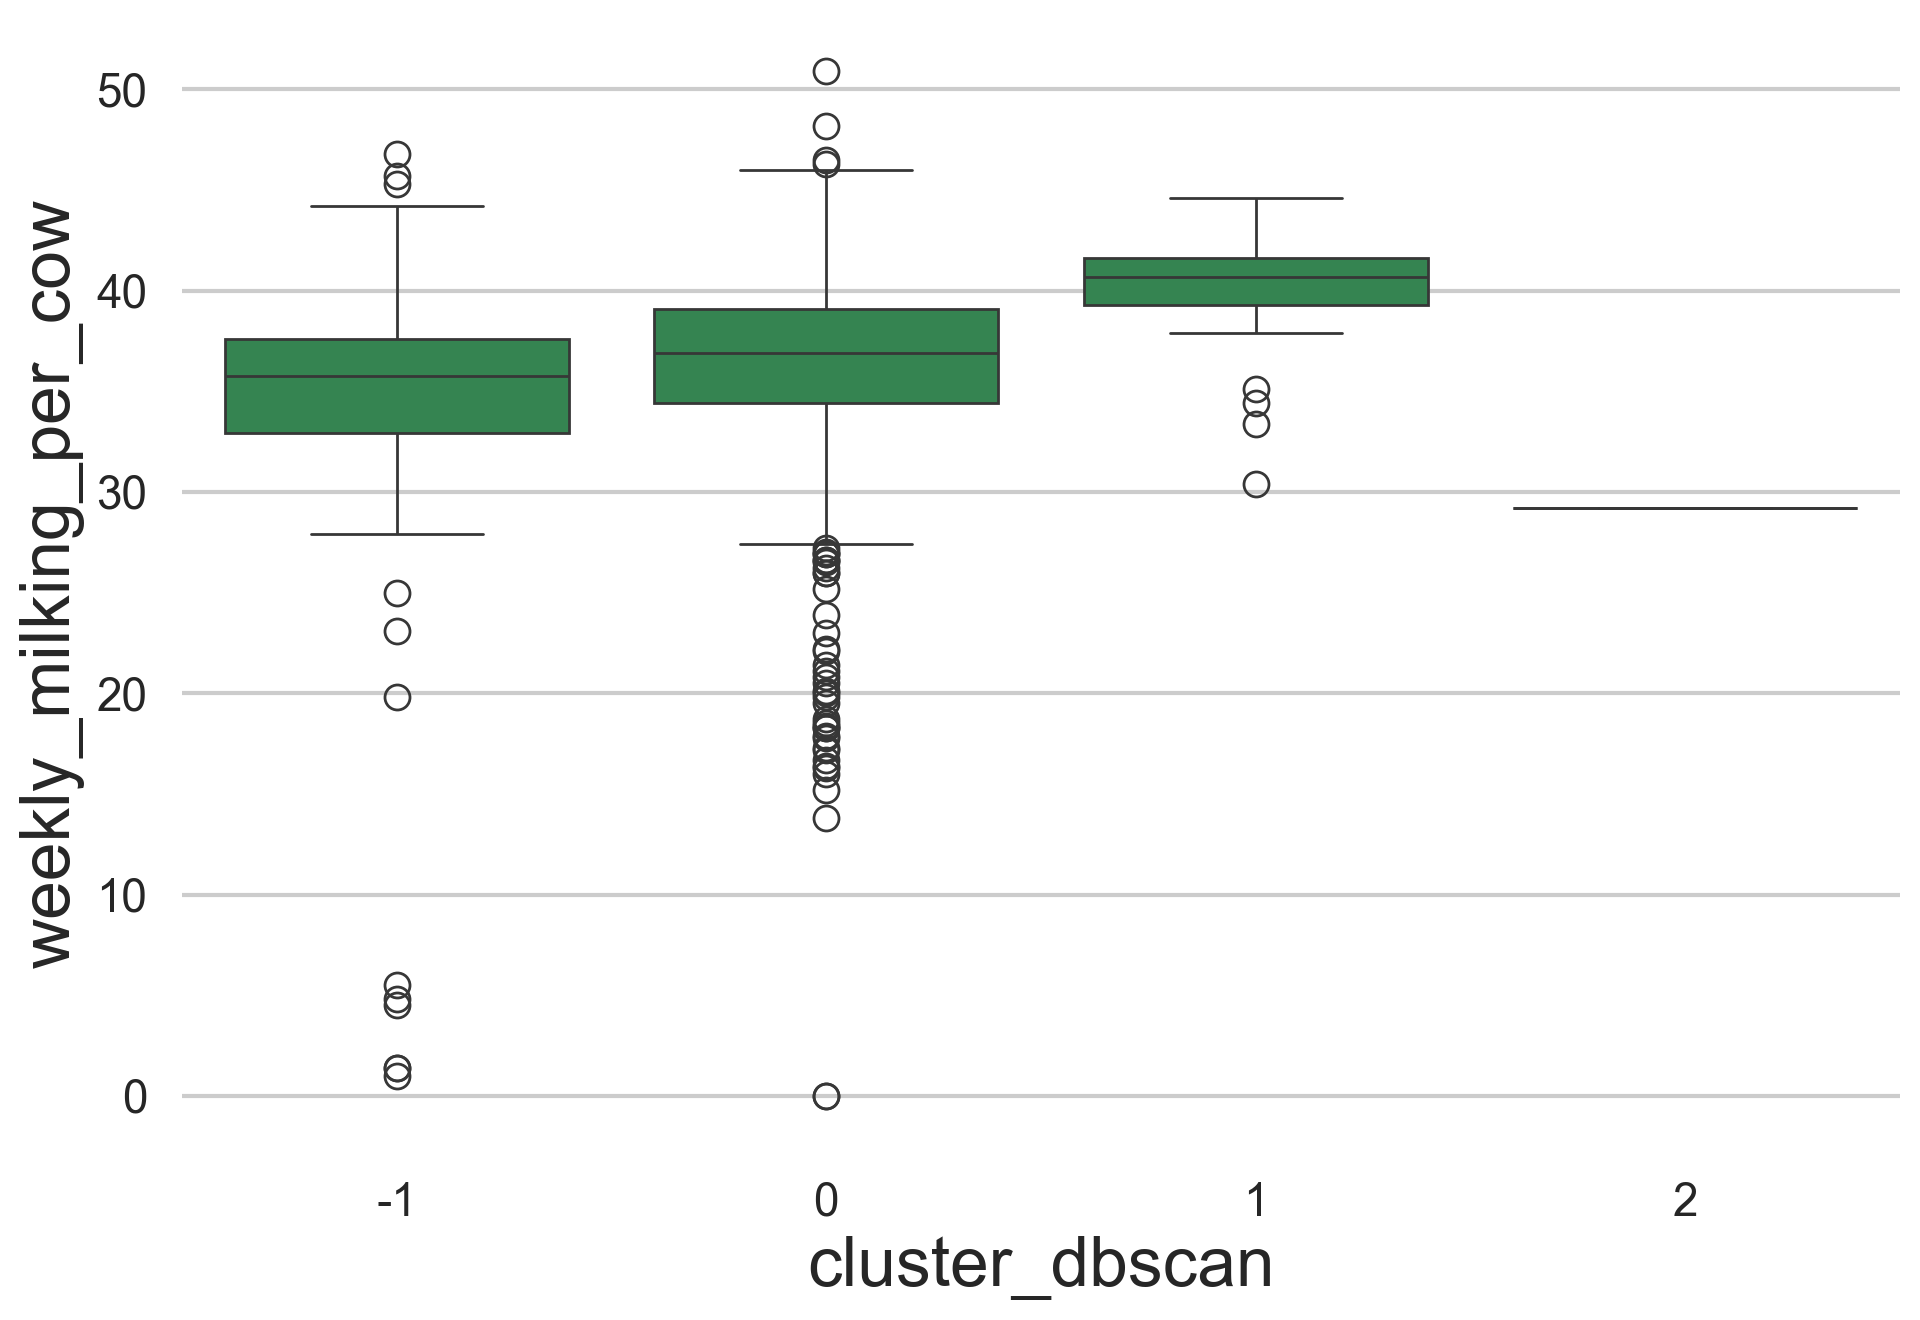

In [210]:
from scipy.stats import f_oneway

div_vectors = pd.read_csv("monthly_div_vectors.csv", index_col=0)
production_indicators["year_month"] = (production_indicators["date"] - pd.DateOffset(months=1)).dt.to_period('M').astype(str)
milking_feeding = pd.merge(production_indicators, div_vectors.rename(columns={"FarmName": "farm_name"}), on=["year_month", "farm_name"])
milking_feeding

groups = [
    g["weekly_milking_per_cow"].dropna().values
    for _, g in milking_feeding.groupby("cluster_dbscan")
]

f_stat, p_val = f_oneway(*groups)

print("F-statistic:", f_stat)
print("p-value:", p_val)

sns.boxplot(milking_feeding, x="cluster_dbscan", y="weekly_milking_per_cow")

In [137]:
herd_metrics["year_month"] = (herd_metrics["date"] - pd.DateOffset(months=1)).dt.to_period('M').astype(str)
herd_metrics

,date,region,prod_farm_name,farm_type,farm_name,ls_capacity,ls_occupancy,forage_cow,milk_cow,dry_cow,milk_marketab_prc,forcow_milk_yeild,forcow_milk_yeild_stand,milk_fat,milk_protein,somatic_cells,bac_contam,cow_retired,cow_lame,cow_mastits,calves,cow_metrit,ph_urine_avr,year_month
0,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров,2800.0,95.535714,2675.0,2329.0,346.0,94.0,NaN,NaN,NaN,NaN,92.0,41.00,52.0,90.0,57,NaN,NaN,NaN,2019-12
1,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров-2,2800.0,101.678571,2847.0,2378.0,469.0,96.0,NaN,NaN,NaN,NaN,90.0,29.00,30.0,44.0,27,NaN,NaN,NaN,2019-12
2,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Верхний Икорец,2800.0,101.071429,2830.0,2363.0,467.0,96.0,NaN,NaN,NaN,NaN,161.0,72.00,52.0,57.0,77,NaN,NaN,NaN,2019-12
3,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Петропавловка,2800.0,59.321429,1661.0,1632.0,29.0,99.0,NaN,NaN,NaN,NaN,69.0,8.00,35.0,120.0,26,NaN,NaN,NaN,2019-12
4,2020-01-01,Воронеж,ЭНА Восток,МТФ,МТФ Владимировка,467.0,37.473233,175.0,175.0,0.0,96.0,NaN,NaN,NaN,NaN,259.0,58.00,17.0,2.0,10,NaN,NaN,NaN,2019-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4296,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Елбань,6200.0,95.000000,5882.0,5468.0,414.0,98.0,32.20,33.9,3.9,3.4,102.5,39.36,526.0,186.0,90,812.0,132.0,5.8,2025-06
4297,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Пеньково,4700.0,99.000000,4666.0,4172.0,494.0,95.0,30.11,31.8,3.9,3.4,114.0,46.00,189.0,305.0,75,843.0,123.0,6.3,2025-06
4298,2025-07-01,Сибирь,Сибирская Нива Маслянино,РМ,РМ Пеньково,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-06
4299,2025-07-01,Сибирь,Сибирская Нива Черепаново,ЖК,ЖК Огнева Заимка,3550.0,100.000000,3544.0,3141.0,403.0,94.0,34.95,36.0,3.8,3.3,91.0,38.00,115.0,124.0,47,514.0,131.0,6.5,2025-06


In [163]:
herd_metrics = pd.read_excel("datasets/Ekoniva_dataset.xlsx", sheet_name="Herd maintenance").replace("-", np.nan)
herd_metrics["year_month"] = (herd_metrics["date"] - pd.DateOffset(months=1)).dt.to_period('M').astype(str)
herd_metrics

,date,region,prod_farm_name,farm_type,farm_name,ls_capacity,ls_occupancy,forage_cow,milk_cow,dry_cow,milk_marketab_prc,forcow_milk_yeild,forcow_milk_yeild_stand,milk_fat,milk_protein,somatic_cells,bac_contam,cow_retired,cow_lame,cow_mastits,calves,cow_metrit,ph_urine_avr,year_month
0,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров,2800.0,95.535714,2675.0,2329.0,346.0,94.0,NaN,NaN,NaN,NaN,92.0,41.00,52.0,90.0,57,NaN,NaN,NaN,2019-12
1,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров-2,2800.0,101.678571,2847.0,2378.0,469.0,96.0,NaN,NaN,NaN,NaN,90.0,29.00,30.0,44.0,27,NaN,NaN,NaN,2019-12
2,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Верхний Икорец,2800.0,101.071429,2830.0,2363.0,467.0,96.0,NaN,NaN,NaN,NaN,161.0,72.00,52.0,57.0,77,NaN,NaN,NaN,2019-12
3,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Петропавловка,2800.0,59.321429,1661.0,1632.0,29.0,99.0,NaN,NaN,NaN,NaN,69.0,8.00,35.0,120.0,26,NaN,NaN,NaN,2019-12
4,2020-01-01,Воронеж,ЭНА Восток,МТФ,МТФ Владимировка,467.0,37.473233,175.0,175.0,0.0,96.0,NaN,NaN,NaN,NaN,259.0,58.00,17.0,2.0,10,NaN,NaN,NaN,2019-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4296,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Елбань,6200.0,95.000000,5882.0,5468.0,414.0,98.0,32.20,33.9,3.9,3.4,102.5,39.36,526.0,186.0,90,812.0,132.0,5.8,2025-06
4297,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Пеньково,4700.0,99.000000,4666.0,4172.0,494.0,95.0,30.11,31.8,3.9,3.4,114.0,46.00,189.0,305.0,75,843.0,123.0,6.3,2025-06
4298,2025-07-01,Сибирь,Сибирская Нива Маслянино,РМ,РМ Пеньково,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-06
4299,2025-07-01,Сибирь,Сибирская Нива Черепаново,ЖК,ЖК Огнева Заимка,3550.0,100.000000,3544.0,3141.0,403.0,94.0,34.95,36.0,3.8,3.3,91.0,38.00,115.0,124.0,47,514.0,131.0,6.5,2025-06


F-statistic: 2.732309558886136
p-value: 0.06542762725939749


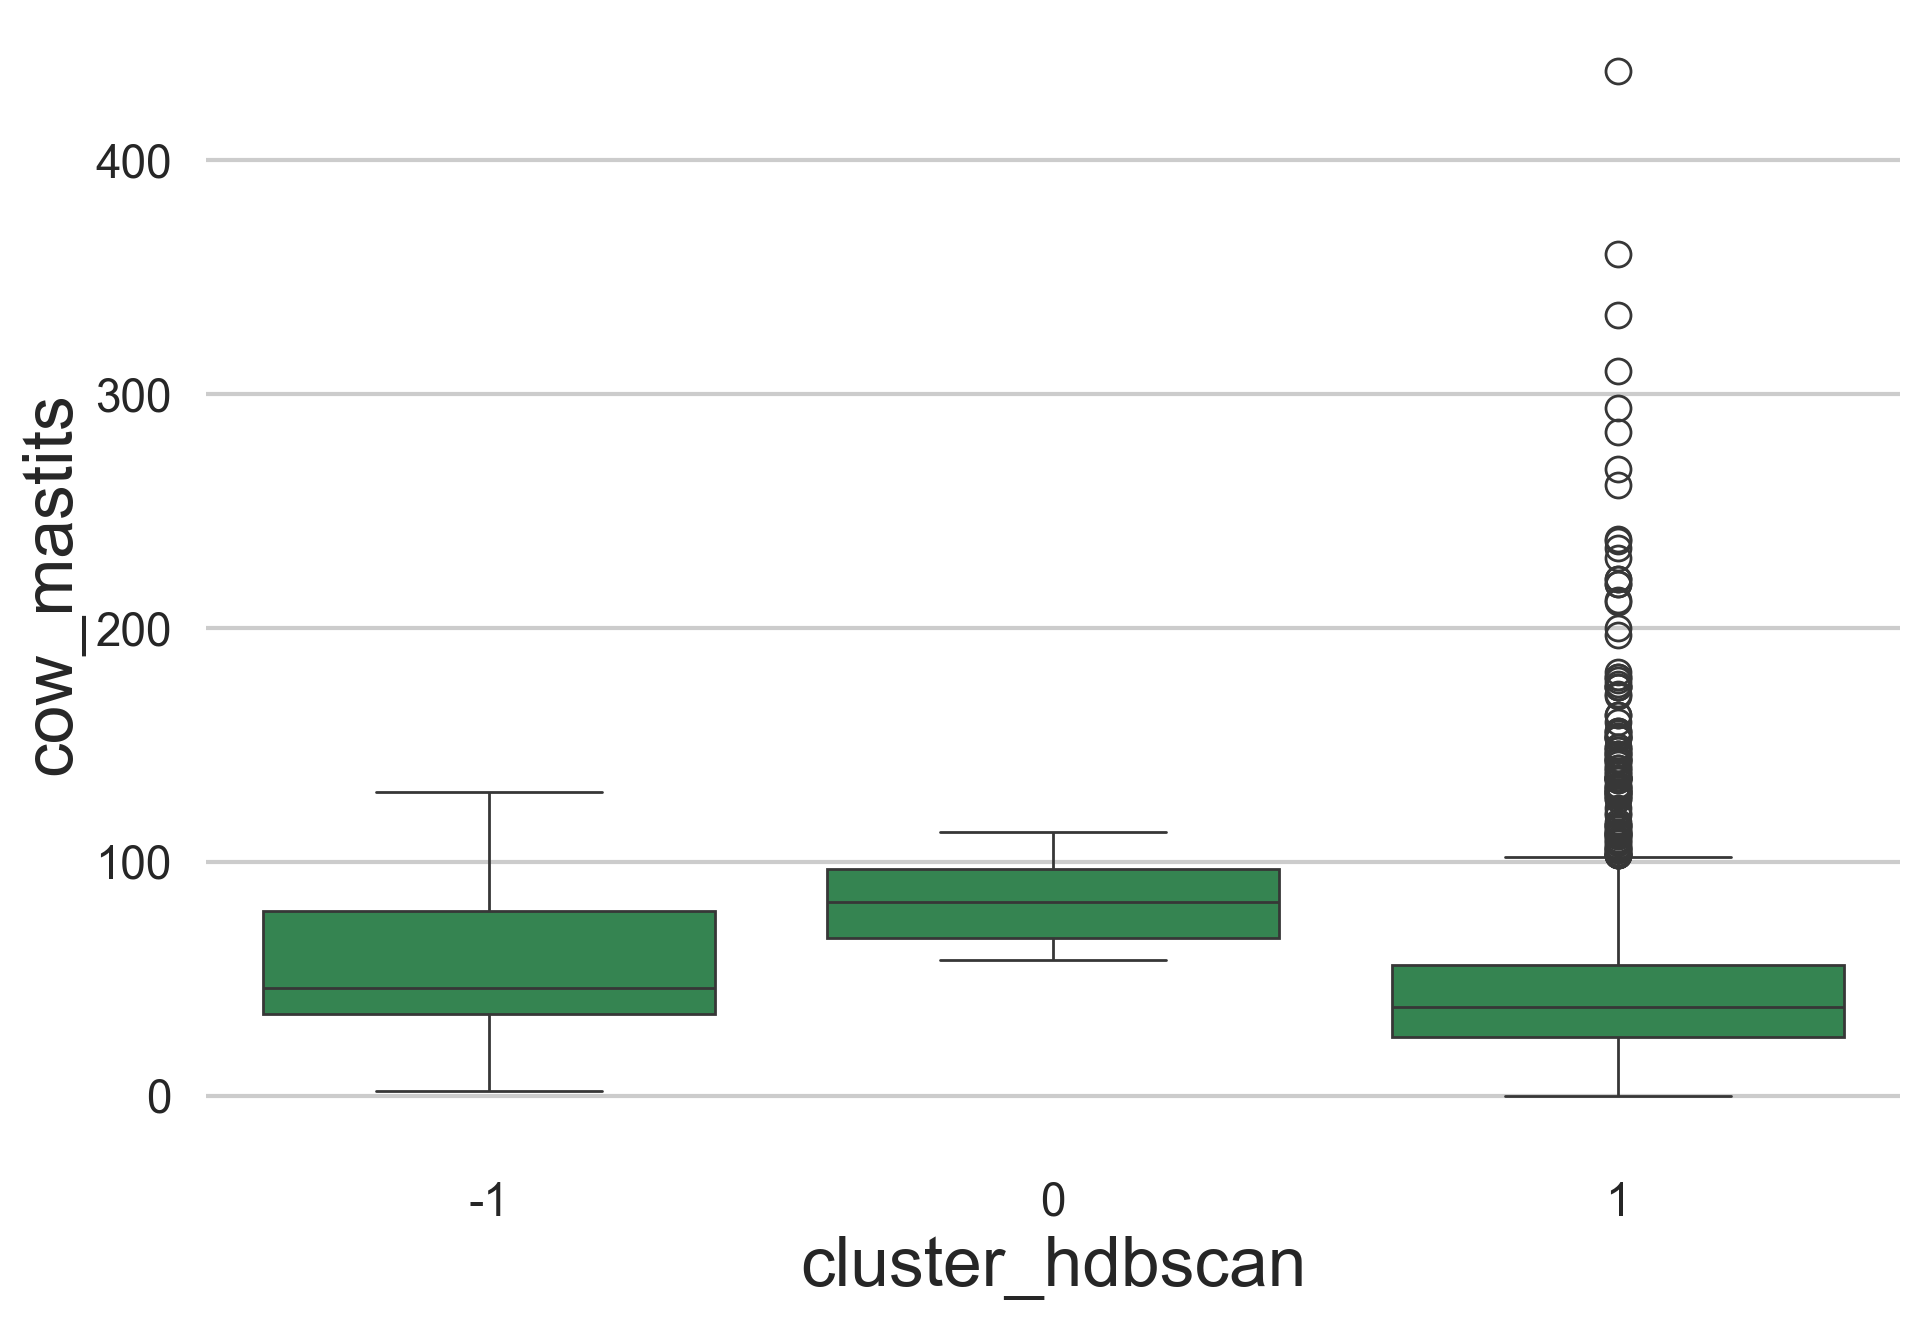

In [207]:
mont = pd.read_csv('monthly_vectors.csv', index_col=0)

herd_metrics.rename(columns={'farm_name': 'FarmName'}, inplace=True)
df = pd.merge(mont, herd_metrics, on=['year_month', 'FarmName'], how='inner')
df['cow_mastits'] = df["cow_mastits"].replace({"83-": "83"})
df['cow_mastits'] = pd.to_numeric(df['cow_mastits'], errors='coerce')
sns.boxplot(df, x="cluster_hdbscan", y="cow_mastits")
groups = [
    g["cow_mastits"].dropna().values
    for _, g in df.groupby("cluster_hdbscan")
]

f_stat, p_val = f_oneway(*groups)

print("F-statistic:", f_stat)
print("p-value:", p_val)

<Axes: xlabel='cluster_dbscan', ylabel='cow_mastits'>

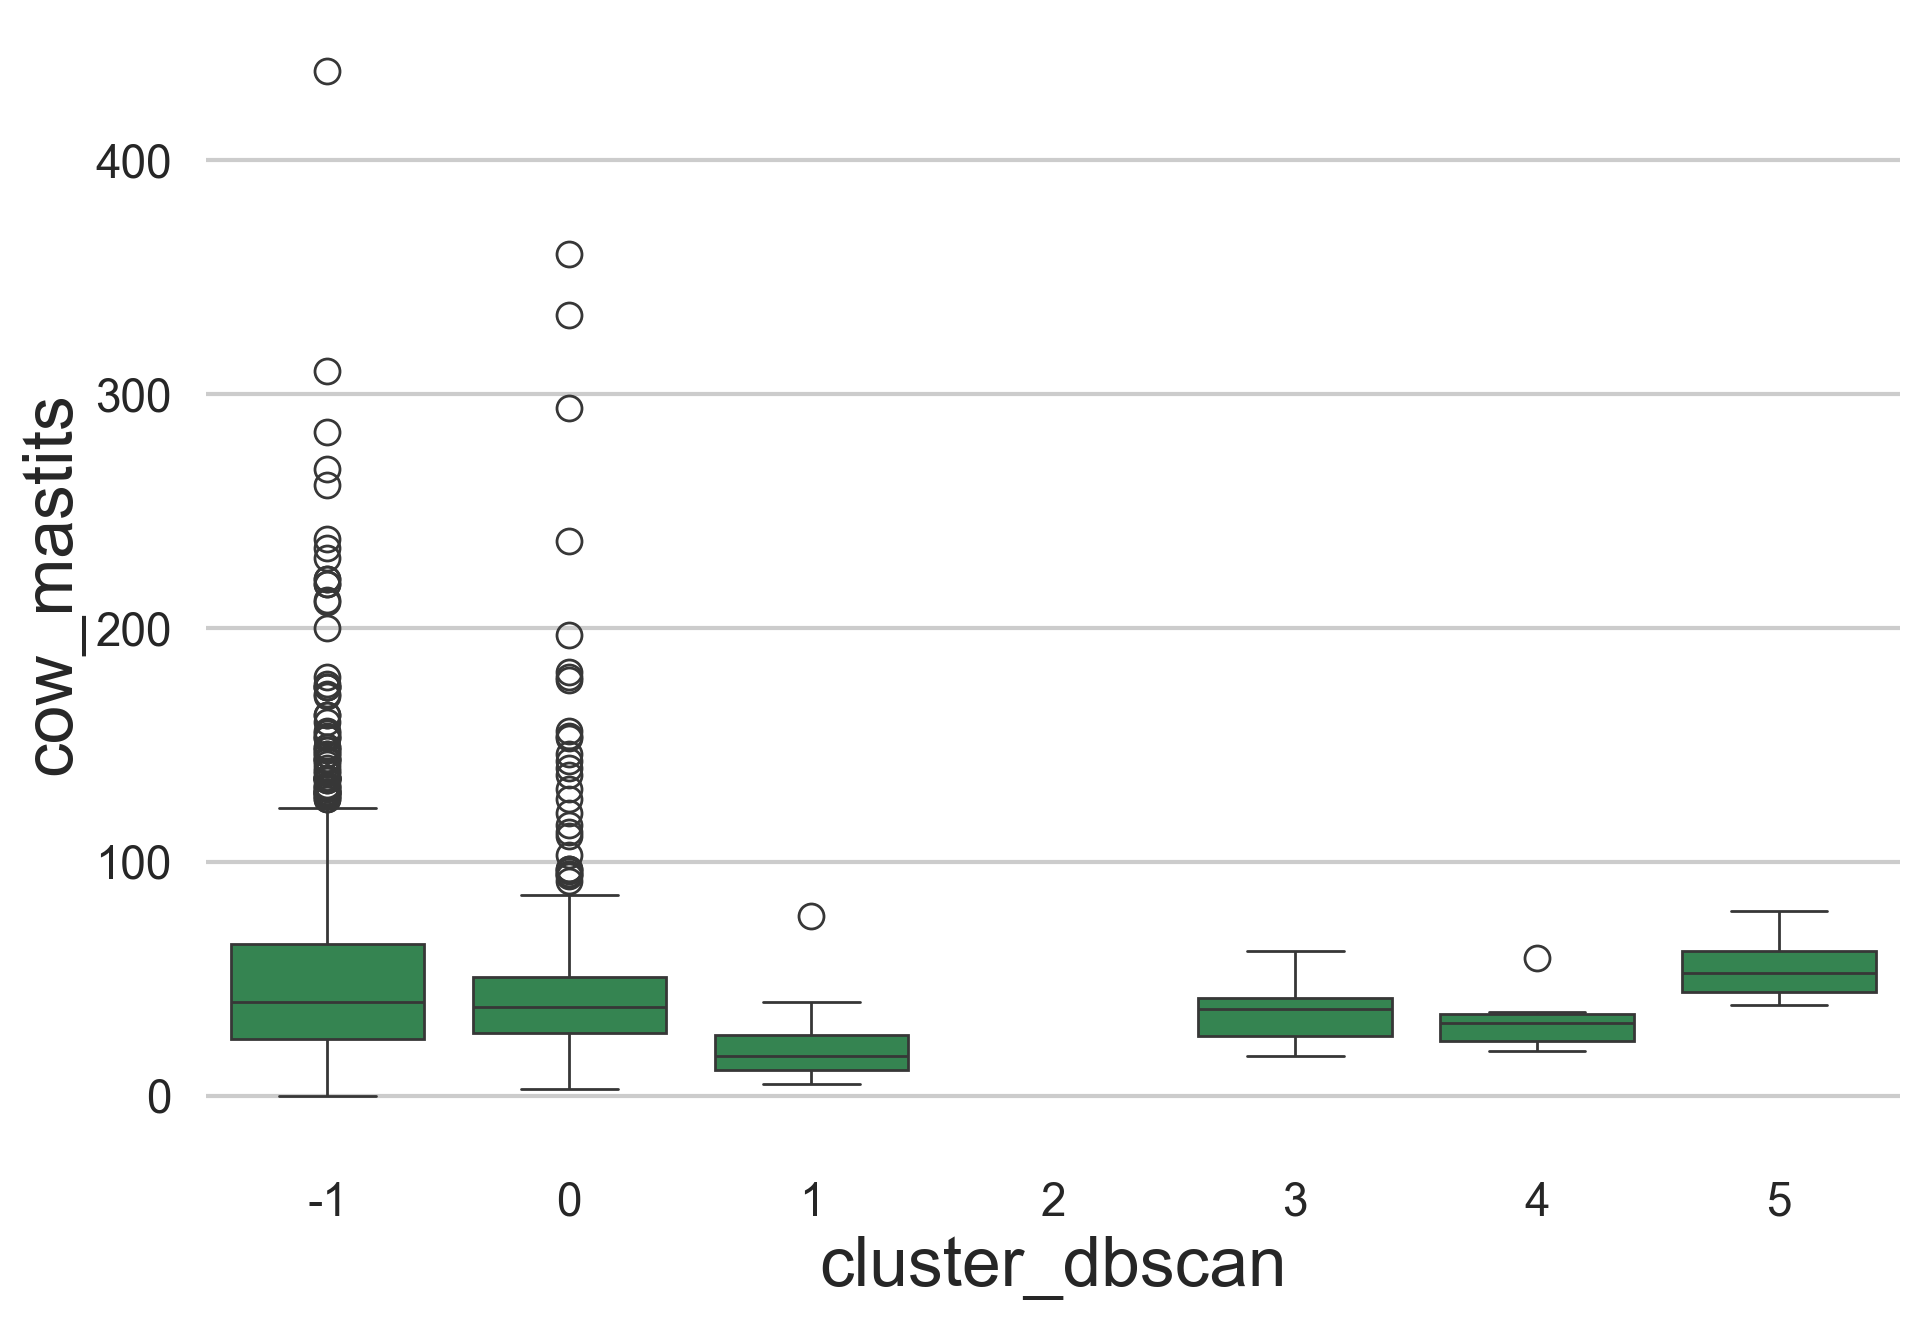